# Machine Learning Foundation

## Section 2, Part c: Cross Validation 

## Learning objectives

By the end of this lesson, you will be able to:

* Chain multiple data processing steps together using `Pipeline`
* Use the `KFolds` object to split data into multiple folds.
* Perform cross validation using SciKit Learn with `cross_val_predict` and `GridSearchCV`


In [6]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [111]:
# Note we are loading a slightly different ("cleaned") pickle file
# It is a dictionary in binary form.
boston = pickle.load(open('data/boston_housing_clean.pickle', "rb" ))

In [112]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [113]:
boston_data = boston['dataframe']
boston_description = boston['description']

In [114]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [290]:
boston_data.shape

(506, 14)

In [291]:
boston_data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

### Discussion: 

Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset. 

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?

**Your response below**

#### Coding this up

The [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object in SciKit Learn tells the cross validation object (see below) how to split up the data:

In [116]:
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

In [124]:
# The train-test/valiation splits are all mutually exclusive,
# i.e., the test/validation splits do not overlap,
# but the train indices can overlap
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [125]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [126]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.6719348798472775, 0.7485020059212364, 0.6976807323597769]

A bit cumbersome, but do-able.

### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?

**Your response below**

### Coding this up

In [130]:
# Initialize model and empty array of scores (one for each split)
scores = []
lr = LinearRegression()
s = StandardScaler()

# Get indices of each split, fit model, evaluate and get metric/score
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test)
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)

In [131]:
# We see that different test splits lead to quite different scores
# Thus, the importance of ddoing cross-validation
scores

[0.6719348798472715, 0.748502005921238, 0.6976807323597745]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome! 

_Very_ luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

### `Pipeline` and `cross_val_predict`

`Pipeline` lets you chain together multiple operators on your data that both have a `fit` method.

In [132]:
s = StandardScaler()
lr = LinearRegression()

### Combine multiple processing steps into a `Pipeline`

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.  

In [141]:
# The tuple objects have: (name, object)
# The object array must be a ssequence of objects with these properties
# - all need to have a fit() method
# - all but the last need to have a transform() method
# - the final one must have a predict() method
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

In [143]:
# We can now use the estimator as a model
estimator.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regression', LinearRegression())])

In [144]:
estimator.predict(X_test)

array([19.44230308, 22.8687781 , 20.72201438, 20.19685225, 16.02553328,
       13.19670707, 18.48717304, 16.41260539, 20.08040483, 19.16027923,
       23.03341265, 23.52809897, 24.64808538, 23.84554003, 22.37992895,
       18.54423788,  9.23453025, 24.86310535, 27.35965358, 29.95093715,
       21.71928179, 18.63649236, 19.67735609, 29.98064881, 20.78659698,
       17.29484103, 20.88767674, 23.59352298, 23.01287114, 24.82516061,
       28.1550891 , 26.59019417, 28.40170962, 28.61954803, 28.99730977,
       25.46130359, 20.83346878, 21.39384122, 21.12590183, 24.80991192,
       22.64896843, 20.63582629, 20.04498128, 20.28679691, 16.04272023,
       15.75494076, 12.78067624, 11.43558055, 21.98898014, 23.31730716,
       24.28692882, 21.28789025, 14.88646576, 31.00959189, 35.37282463,
       37.57270926, 23.58942636, 24.75302163, 30.63215847, 34.85770942,
       32.94090699, 30.0536187 , 39.86200512, 29.05010705, 35.53401305,
       41.89294309, 23.54417467, 23.61752172,  8.51966664, 24.38

### `cross_val_predict`

[`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [211]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [212]:
# The data is split according to the cv parameter.
# Each sample belongs to exactly one test set, 
# and its prediction is computed with an estimator fitted on the corresponding training set.
# Thus the predictions are a compilation of results on different non-overlapping test splits.
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [213]:
predictions.shape

(506,)

In [214]:
# This is not a real R2, because the results are a compilation 
# of different models
r2_score(y, predictions)

0.839054936432341

In [215]:
np.mean(scores) # almost identical!

0.8507649765436147

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models. 

When we are done, `estimator` is still not fitted. If we want to predict on _new_ data, we still have to train our `estimator`. 

## Hyperparameter tuning

### Definition

**Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that _generalizes_ well outside of your sample.

### Mechanics

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html#numpy.geomspace) function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:

In [292]:
# Regularization alpha: the larger, the less complex the model, less overfitting
# Logarithmic jumps in a range
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

The code below tunes the `alpha` hyperparameter for Lasso regression.

In [217]:
# Lasso and Ridge regression: alpha coefficient = factor of the regularization term
# Low alpha: more complex model, more similar to linear regression
# High alpha: less complex model
# We want to find the optimum alpha
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    # For regular regression scaling does not affect so much
    # but for any regularized regression it does.
    # Always scale before fitting the model!
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [218]:
list(zip(alphas,scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602441),
 (1e-06, 0.7063531882052065),
 (1e-05, 0.7063539165191506),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.7058381511671851),
 (1.0, 0.6512724532884887)]

In [219]:
# Small alpha values make coefficients do not remove the coefficients
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [220]:
# Large alpha values make coefficients -> 0, i.e., we simplify our model
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

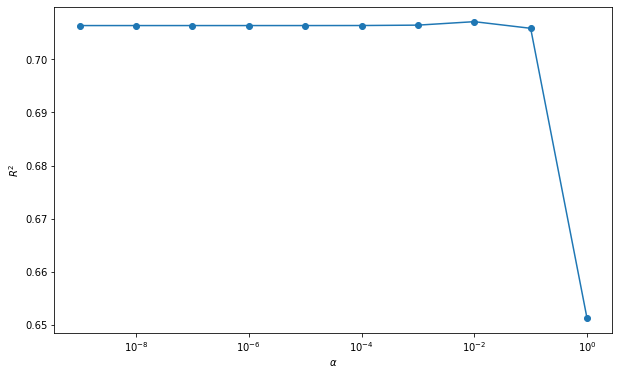

In [221]:
# Plot alpha vs. score: select optimum
# Note: we use semilogx
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [222]:
# Optimum alpha maximizes score
alphas[np.argmax(scores)]

0.01

### Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

In [232]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(1e-3, 1.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=10000)
    
    # Best practice: scale before fitting and after any feature engineering
    # to keep the desired scale
    estimator = Pipeline([
        ("make_higher_degree", pf),
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e+02, tolerance: 2.735e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+02, tolerance: 2.777e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

If you store the results in a list called `scores`, the following will work:

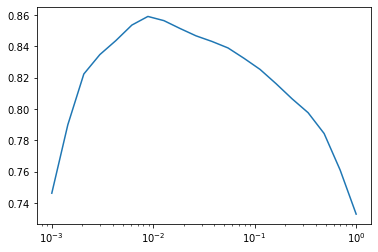

In [233]:
plt.semilogx(alphas, scores);

In [234]:
# Optimum alpha maximizes score
alphas[np.argmax(scores)]

0.008858667904100823

In [235]:
np.max(scores)

0.8590525582375538

In [236]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data.
# Now, we should get a new test dataset that NEVER was exposed to the model.
# However, here we don't have one and we compute the score with the complete dataset we have instead.
# A way of doing that would be to make a train-test split at the beginning
# and then perform the k-fold cross validation on the train split.
best_estimator = Pipeline([
                    ("scaler", s),
                    ("polynomial_features", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.01))])

best_estimator.fit(X, y)
best_estimator.score(X, y) # the default score is R2 for regression models

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.965e+01, tolerance: 4.272e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


0.9241797703677183

In [237]:
# Note that many coefficients are zeroed out;
# that is usual with the Lasso regression.
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.        ,  0.        ,  0.        ,  0.89576743,  0.        ,
       -1.2379132 ,  3.42996135, -1.45409732, -2.81278867,  0.09552996,
       -0.04749177, -0.48059771,  0.8527216 , -3.3079961 ,  0.11754404,
       -0.        ,  0.        ,  4.59961981, -0.51472196,  0.69238495,
       -0.        , -0.        , -0.78335584,  0.        , -0.        ,
       -0.1135307 ,  0.88515977,  0.15662733, -0.07243429, -0.04507525,
       -0.        ,  0.05231371, -0.14750539, -0.3435876 , -0.        ,
        1.08946116, -0.06583398, -0.        , -0.504731  ,  0.58570768,
        0.        ,  2.3604961 ,  0.937711  ,  0.23400448,  1.02253938,
       -0.        ,  0.15091893, -0.39936423,  0.16552476, -0.60300865,
        0.46048655, -0.90520874, -0.8646163 ,  0.22884895,  0.10712925,
       -0.12425553,  0.        , -0.19385065,  0.16805402, -0.43770119,
       -0.62373059, -0.06248739, -0.95426573,  1.17294554, -0.77112082,
        0.        , -0.83078648, -0.        ,  0.59248786,  0.16

### Exercise

Do the same, but with `Ridge` regression 

Which model, `Ridge` or `Lasso`, performs best with its optimal hyperparameters on the Boston dataset?

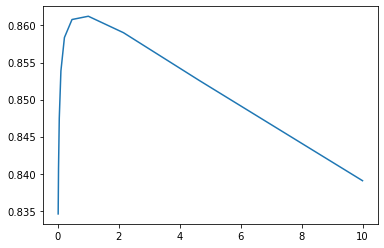

In [238]:
# We do the same thing as before
# Low alpha: more complexity
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(1e-2, 10, 10)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)
    
    # Best practice: scale before the model fitting
    estimator = Pipeline([
        ("polynomial_features", pf),
        ("scaler", s),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

In [239]:
# Optimum alpha maximizes score
alphas[np.argmax(scores)]

1.0

In [240]:
np.max(scores)

0.8612466079014787

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

### Exercise: Feature Importances (Intepretability)

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.


In [246]:
# Once we have found the model and its hyperparameters
# fit the model and train it on ALL the data.
# Here the Lasso model with aplha=0.03 is taken, but the experiments seem to
# show that the Ridge model with alpha=1 would have been better.
best_estimator = Pipeline([
                    ("scaler", s),
                    ("polynomial_features", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9134777735196521

In [264]:
# We can access the elements of the Pipeline with .named_steps["object_name"] 
df_importances = pd.DataFrame(zip(best_estimator.named_steps["polynomial_features"].get_feature_names_out(input_features=X.columns),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [265]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [266]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [267]:
df_importances.sort_values(by=1)

,0,1
13,LSTAT,-3.395426
8,DIS,-2.561614
10,TAX,-1.722662
94,RAD LSTAT,-1.124408
72,RM RAD,-1.085987
...,...,...
9,RAD,1.127783
79,AGE RAD,1.363407
96,TAX PTRATIO,1.962870
6,RM,3.326791


<BarContainer object of 105 artists>

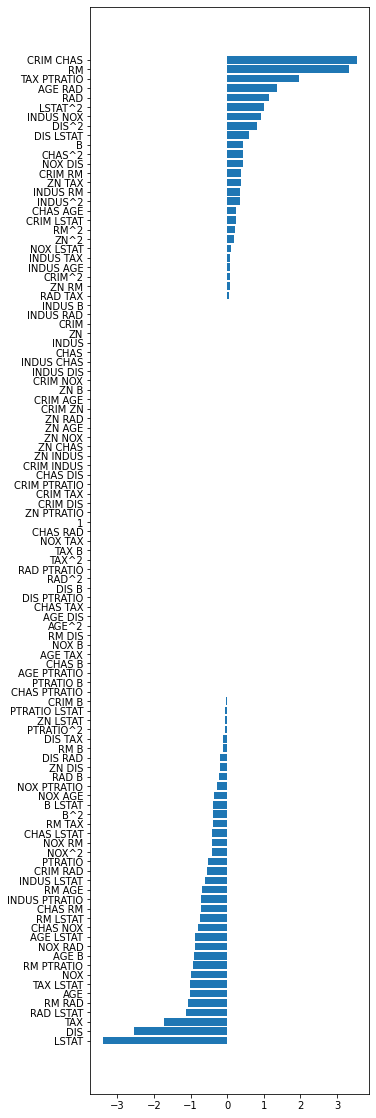

In [269]:
fig = plt.figure(figsize=(5,20))
plt.barh(df_importances.sort_values(by=1).iloc[:,0],df_importances.sort_values(by=1).iloc[:,1])

In [271]:
print(boston_description)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

## Grid Search CV

To do cross-validation, we used two techniques:
- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:
- use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

In [272]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([
    ("polynomial_features", PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("ridge_regression", Ridge())])

# We copose a dictionary with parameter values to test or to look up
# If the estimator is a model: {'paramater':[value_array]}
# If the estimator is a Pipeline: {'object_name__parameter':[value_array]}; note the double '_'!
params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(1e-3, 20, 30)
}

# Instantiate a grid search for cross-validation
grid = GridSearchCV(estimator, params, cv=kf)

In [283]:
# Find the optimal parameters
# Basically, the estimator is fit going through all parameter combinations:
# 3 degrees x 30 alphas = 90 combinations
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([1.00000000e-03, 1.40705599e-03, 1.97980656e-03, 2.78569867e-03,
       3.91963400e...3, 1.09189192e-02,
       1.53635307e-02, 2.16173479e-02, 3.04168189e-02, 4.27981672e-02,
       6.02194175e-02, 8.47320920e-02, 1.19222798e-01, 1.67753151e-01,
       2.36038076e-01, 3.32118789e-01, 4.67309731e-01, 6.57530956e-01,
       9.25182870e-01, 1.30178410e+00, 1.83168311e+00, 2.57728069e+00,
       3.62637824e+00, 5.10251722e+00, 7.17952741e+00, 1.01019970e+01,
       1.42140755e+01, 2.00000000e+01])})

In [284]:
# Get best values: cross-validation score and parameters associated wwith it
grid.best_score_, grid.best_params_

(0.8615308203747548,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 0.9251828702516218})

In [285]:
# The best parameter set is taken and the estimator used to predict
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
y_predict = grid.predict(X)

In [286]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.9119069667745816

In [287]:
# We can access any Pipeline object of the best estimator
# and their attributes & methods!
# Here, the model coefficients
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  2.66005155e-01, -2.42725203e+00,  2.12539006e-01,
        2.51410004e+00,  2.20352450e+00,  5.43834678e+00,  4.19634494e+00,
       -5.02068959e+00,  5.13057721e+00,  2.26217758e+00,  1.00962742e+00,
        2.99248333e+00,  1.79132257e+00,  1.32490980e+00,  1.16230239e-01,
        1.14859318e+00,  2.53008902e+00, -2.50802714e+00,  6.43964254e-01,
       -1.39742248e+00, -7.92546731e-01, -1.08342773e+00, -1.44841337e-01,
        1.81418605e-03, -4.85069483e-01,  1.45983319e+00,  7.47637551e-01,
       -1.85320990e-01, -1.51488925e-01, -6.68350461e-01,  1.44525085e+00,
       -5.77689166e-02, -1.44248091e+00, -3.31481021e-01,  2.24506080e+00,
        1.67900087e+00, -5.43334819e-01, -8.19041352e-01,  1.90466311e+00,
        1.33968567e-01,  1.46019503e+00, -1.13807851e+00,  2.02059444e+00,
       -2.08427984e-01,  1.97367098e+00,  2.00591786e+00, -2.69932081e+00,
        4.16473652e-01, -3.92917300e+00,  2.51410004e+00, -3.00125514e+00,
       -5.31887969e+00,  

In [293]:
# Get the model statistics/properties of each parameter combination
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008917,0.006787,0.002467,0.001189,1,0.001,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671935,0.748502,0.697682,0.706040,0.031812,77
1,0.004349,0.001286,0.001288,0.000197,1,0.001407,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671935,0.748502,0.697683,0.706040,0.031812,76
2,0.004665,0.001627,0.001101,0.000041,1,0.00198,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671935,0.748502,0.697683,0.706040,0.031812,75
3,0.002558,0.000044,0.001058,0.000025,1,0.002786,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671935,0.748502,0.697684,0.706041,0.031812,74
4,0.002196,0.000171,0.000877,0.000066,1,0.00392,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671935,0.748502,0.697686,0.706041,0.031812,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.006962,0.000174,0.001736,0.000460,3,5.102517,"{'polynomial_features__degree': 3, 'ridge_regr...",0.823121,0.872499,0.856767,0.850796,0.020596,17
86,0.007917,0.000048,0.002578,0.000145,3,7.179527,"{'polynomial_features__degree': 3, 'ridge_regr...",0.825794,0.871786,0.859259,0.852280,0.019414,13
87,0.007855,0.000159,0.001947,0.000623,3,10.101997,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827345,0.870495,0.860317,0.852719,0.018417,12
88,0.008007,0.000156,0.001649,0.000381,3,14.214075,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827839,0.868580,0.860083,0.852167,0.017549,14


## Summary

1. We can manually generate folds by using `KFolds`
2. We can get a score using `cross_val_predict(X, y, cv=KFoldObject_or_integer)`. 
   This will produce the out-of-bag prediction for each row.
3. When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using `cross_val_predict` in a loop, or ....
4. .... use `GridSearchCV`. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

### Extensions

Here are some additional items to keep in mind:
* There is a `RandomSearchCV` that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
* KFolds will randomly select rows to be in the training and test folds. There are other methods (such as `StratifiedKFolds` and `GroupKFold`, which are useful when you need more control over how the data is split (e.g. to prevent data leakage). You can create these specialized objects and pass them to the `cv` argument of `GridSearchCV`.

---
### Machine Learning Foundation (C) 2020 IBM Corporation